In [1]:
cd ..

/Users/quentinleroy/mva/recvis/project/cmn


In [2]:
from __future__ import absolute_import, division, print_function

import sys
import os; os.environ['CUDA_VISIBLE_DEVICES'] = ''  # using GPU 0

import tensorflow as tf
import numpy as np
import skimage.io
import skimage.transform

from models import visgeno_attention_model, spatial_feat, fastrcnn_vgg_net
from util.visgeno_rel_train.rel_data_reader import DataReader
from util import loss, eval_tools, text_processing

In [3]:
################################################################################
# Parameters
################################################################################

# Model Params
T = 20
num_vocab = 72704
embed_dim = 300
lstm_dim = 1000

# Data Params
imdb_file = './exp-visgeno-rel/data/imdb/imdb_val.npy'
vocab_file = './word_embedding/vocabulary_72700.txt'
im_mean = visgeno_attention_model.fastrcnn_vgg_net.channel_mean

# Snapshot Params
model_file = '/Users/quentinleroy/mva/recvis/project/cmn/downloaded_models/visgeno_attbilstm_strong_iter_360000.tfmodel'

visualize_dir = './exp-visgeno-rel/results/visgeno_attbilstm_weak_iter_360000.val/'

In [4]:
################################################################################
# Network
################################################################################

im_batch = tf.placeholder(tf.float32, [1, None, None, 3])
bbox_batch = tf.placeholder(tf.float32, [None, 5])
spatial_batch = tf.placeholder(tf.float32, [None, 5])
text_seq_batch = tf.placeholder(tf.int32, [T, None])

In [5]:
scores = visgeno_attention_model.visgeno_attbilstm_net(im_batch, bbox_batch, spatial_batch,
    text_seq_batch, num_vocab, embed_dim, lstm_dim, False, False)

In [6]:
np.random.seed(3)
reader = DataReader(imdb_file, vocab_file, im_mean, shuffle=False, max_bbox_num=10000, max_rel_num=10000)

Loading ROI data from file...Done.


In [7]:
################################################################################
# Snapshot and log
################################################################################

# Snapshot saver
snapshot_saver = tf.train.Saver()

# Start Session
# sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))

sess = tf.Session()

# tf.reset_default_graph()


# Run Initialization operations
snapshot_saver.restore(sess, model_file)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

vocab_list = [w.strip() for w in open(vocab_file).readlines()]
def vocab_indices2sentence(indices):
    return ' '.join([vocab_list[idx] for idx in indices if idx != 0])
def print_bbox(bboxes, style='r-', color='#00FF00', linewidth=5):
    """A utility function to help visualizing boxes."""
    bboxes = np.array(bboxes).reshape((-1, 4))
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        xmin-=(linewidth+3)
        ymin-=(linewidth+3)
        xmax+=(linewidth+3)
        ymax+=(linewidth+3)
        plt.plot([xmin, xmax, xmax, xmin, xmin],
                 [ymin, ymin, ymax, ymax, ymin], style, color=color, linewidth=linewidth)

data reader: epoch = 0, batch = 5 / 5000
	this batch: N_lang = 7, N_bbox = 23
data reader: epoch = 0, batch = 6 / 5000
	this batch: N_lang = 63, N_bbox = 28
data reader: epoch = 0, batch = 7 / 5000
	this batch: N_lang = 32, N_bbox = 78
data reader: epoch = 0, batch = 8 / 5000
	this batch: N_lang = 24, N_bbox = 31
data reader: epoch = 0, batch = 9 / 5000
	this batch: N_lang = 29, N_bbox = 31


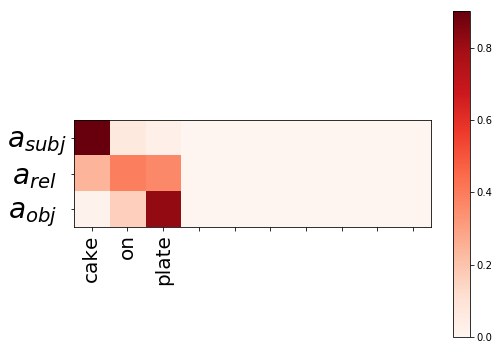

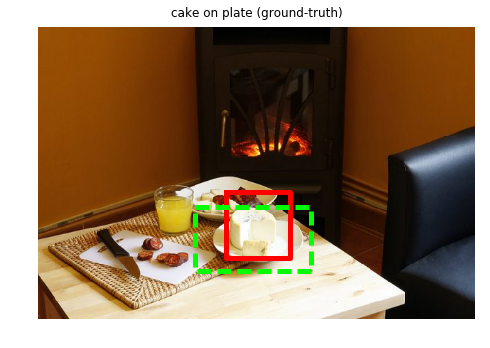

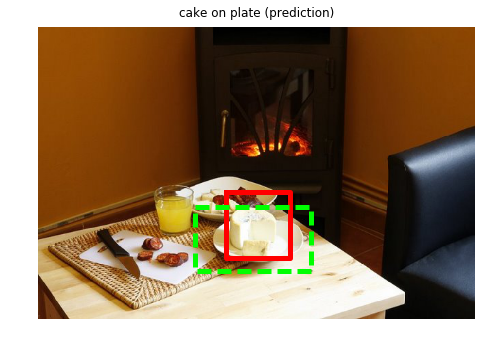

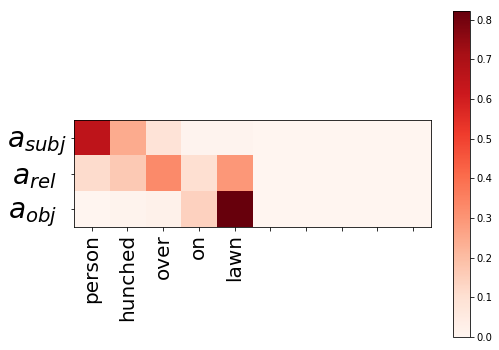

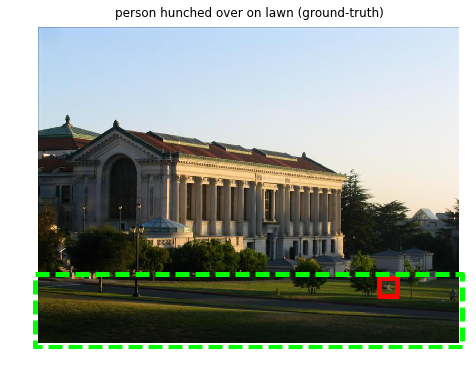

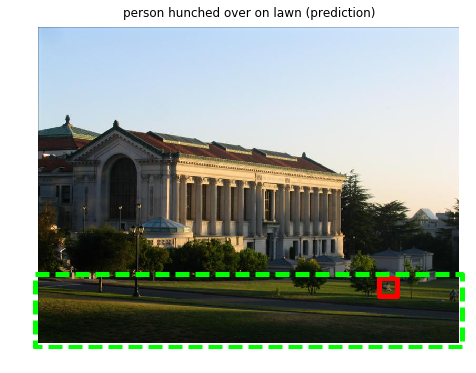

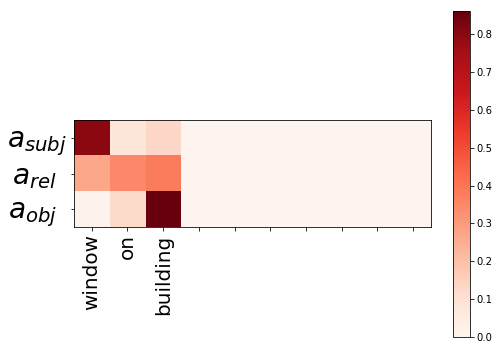

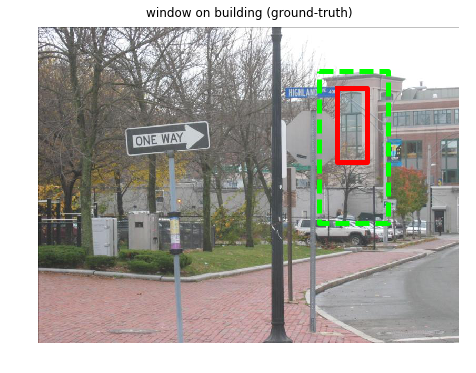

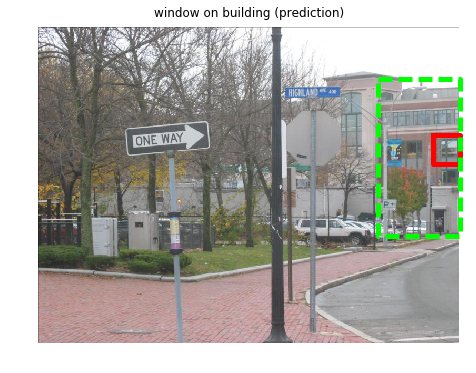

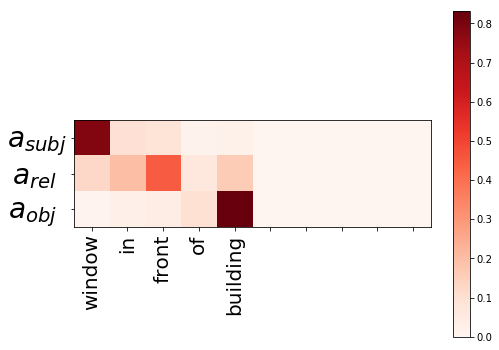

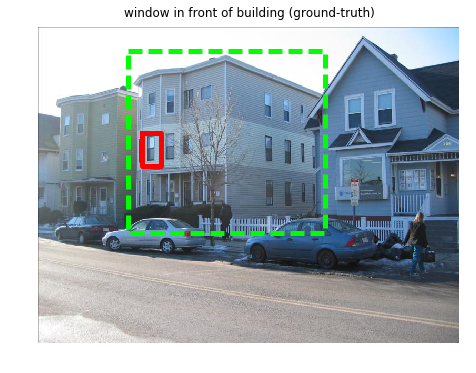

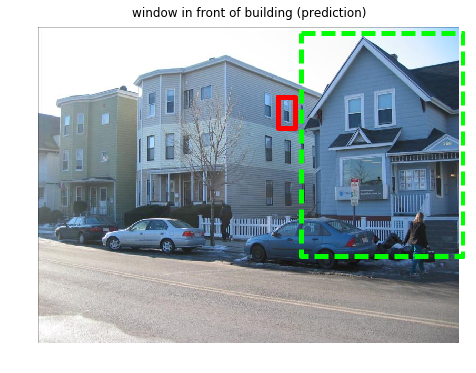

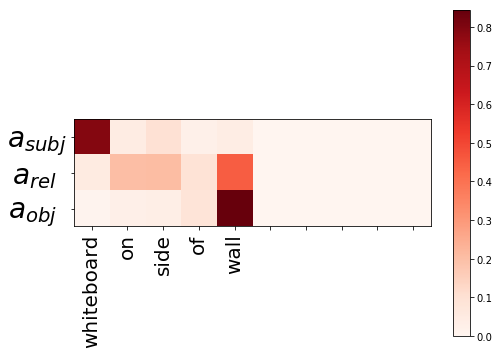

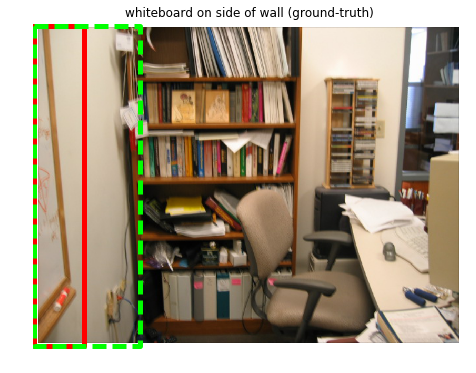

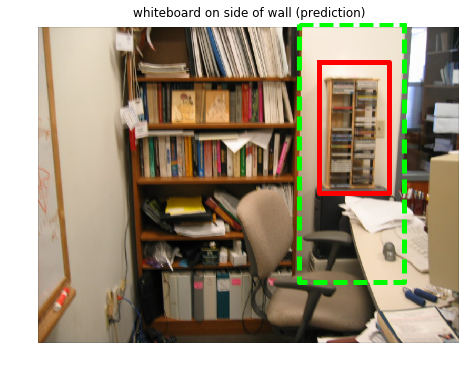

In [10]:
################################################################################
# Optimization loop
################################################################################

if not os.path.isdir(visualize_dir):
    os.mkdir(visualize_dir)

# Run optimization
for n_iter in range(5):
    batch = reader.read_batch()
    print('\tthis batch: N_lang = %d, N_bbox = %d' %
          (batch['expr_obj1_batch'].shape[1], batch['bbox_batch'].shape[0]))

    k = batch['expr_obj1_batch'].shape[1] // 2

    # Forward and Backward pass
    scores_val, ((probs_obj1, probs_obj2, probs_rel),) = sess.run((scores,
            tf.get_collection("attention_probs")),
        feed_dict={
            im_batch            : batch['im_batch'],
            bbox_batch          : batch['bbox_batch'],
            spatial_batch       : batch['spatial_batch'],
            text_seq_batch      : batch['text_seq_batch']
        })

    
    expr = vocab_indices2sentence(batch['text_seq_batch'][:, k])
    is_not_pad = batch['text_seq_batch'][:, k] > 0
    words = [vocab_list[idx] for idx in batch['text_seq_batch'][is_not_pad, k]]

    im = (batch['im_batch'][0] + im_mean).astype(np.uint8)
    bboxes = batch['bbox_batch'][:, 1:]

    plt.figure(figsize=(8, 6))
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, words + ['']*(10-len(words)), rotation=90, fontsize=20)
    plt.yticks([0, 1, 2], ['$a_{subj}$', '$a_{rel}$  ', '$a_{obj}$  '], fontsize=28)
    attention_mat = np.hstack((probs_obj1[is_not_pad, k], probs_rel[is_not_pad, k], probs_obj2[is_not_pad, k])).T
    attention_mat = np.hstack((attention_mat, np.zeros((3, 10-len(words)), attention_mat.dtype)))
    plt.imshow(attention_mat, interpolation='nearest', cmap='Reds')
    plt.colorbar()
    plt.savefig(visualize_dir + '%08d_att.png' % n_iter)

    plt.figure(figsize=(8, 6))
    gt_l = batch['label_batch'][k]
    plt.imshow(im)
    print_bbox(bboxes[gt_l // len(bboxes)], '-', color='#FF0000')
    print_bbox(bboxes[gt_l % len(bboxes)], '--', color='#00FF00')
    plt.title(expr + ' (ground-truth)')
    plt.axis([-10, im.shape[1]+10, -10, im.shape[0]+10])
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.savefig(visualize_dir + '%08d_gt.png' % n_iter)

    plt.figure(figsize=(8, 6))
    pred_l = np.argmax(scores_val[k])
    plt.imshow(im)
    print_bbox(bboxes[pred_l // len(bboxes)], '-', color='#FF0000')
    print_bbox(bboxes[pred_l % len(bboxes)], '--', color='#00FF00')
    plt.title(expr + ' (prediction)')
    plt.axis([-10, im.shape[1]+10, -10, im.shape[0]+10])
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.savefig(visualize_dir + '%08d_pred.png' % n_iter)
    
#     plt.close('all')

In [9]:
for n_iter in range(3):
    batch = reader.read_batch()
    print('\tthis batch: N_lang = %d, N_bbox = %d' %
          (batch['expr_obj1_batch'].shape[1], batch['bbox_batch'].shape[0]))

    # Forward and Backward pass
    scores_val, ((probs_obj1, probs_obj2, probs_rel),) = sess.run((scores,
            tf.get_collection("attention_probs")),
        feed_dict={
            im_batch            : batch['im_batch'],
            bbox_batch          : batch['bbox_batch'],
            spatial_batch       : batch['spatial_batch'],
            text_seq_batch      : batch['text_seq_batch']
        })

    N_batch, N_box, _, _ = scores_val.shape

    # scores_val has shape [N_batch, N_box, N_box, 1]
    scores_obj1 = np.max(scores_val.reshape((N_batch, N_box, N_box)), axis=2)
    # prediction_box_ids has shape [N_batch, K] containing indices
    prediction_box_ids = np.argsort(-scores_obj1, axis=1)[:, :K]  # minus to sort in descending order
    # labels has shape [N_batch, 1] containing indices
    labels = batch['label_weak_batch'].reshape((N_batch, 1))

    is_matched = (prediction_box_ids == labels).astype(np.float32)
    is_matched_cumsum = np.cumsum(is_matched, axis=1)
    matched_ids_count = np.sum(is_matched_cumsum, axis=0)
    top_x_correct_count[:N_box] += matched_ids_count
    top_x_correct_count[N_box:] += N_batch
    total += N_batch

data reader: epoch = 0, batch = 0 / 5000
	this batch: N_lang = 19, N_bbox = 53


ValueError: not enough values to unpack (expected 1, got 0)